In [1]:
import pickle
import os

FOLDER = os.getcwd() + "/5cell_test"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import math
import numpy as np
import random
import time



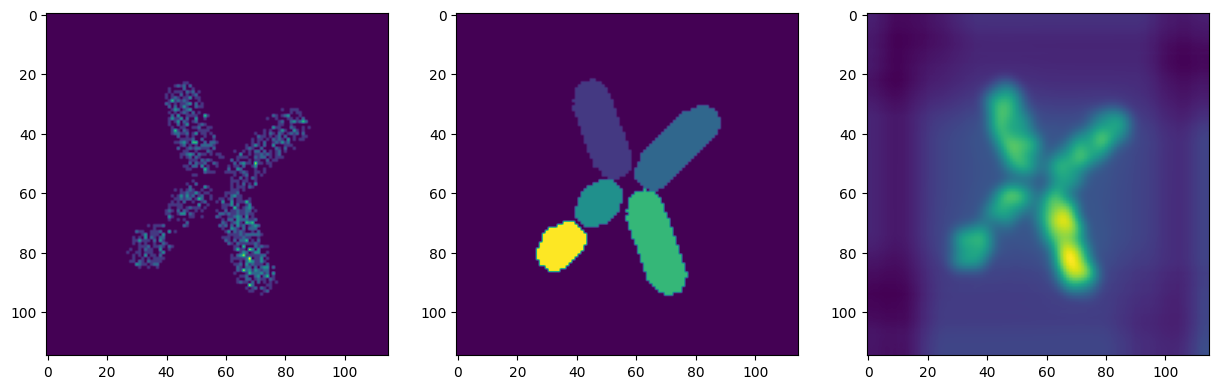

In [3]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

In [4]:
#Final all non zero mask points

sourcePts = []

(maskWidth, maskHeight) = mask.shape

for i in range(maskWidth):
    for j in range(maskHeight):
        if mask[i,j] != 0:
            sourcePts.append([i,j])
print(len(sourcePts))

#Take only a random subset of the sourcePts

random.shuffle(sourcePts)
sourcePts = sourcePts[:]

with open(FOLDER + '/sourcePts.pkl', 'wb') as file: 
    pickle.dump(sourcePts, file)

"""
for k in sourcePts:
    plt.scatter(k[1],k[0],c='r')
plt.imshow(mask)
"""


1681


"\nfor k in sourcePts:\n    plt.scatter(k[1],k[0],c='r')\nplt.imshow(mask)\n"

In [5]:
def AverageFilter(img, x, y):
    sz = [ -2, -1, 0 , 1, 2]
    total = 0
    for i in sz:
        for j in sz:
            total += img[x+i][y+j]
    total/=len(sz)*len(sz)
    return total

outputIntensity = {}
(outputWidth, outputHeight) = out.shape

for pt in sourcePts:
    x = pt[0]
    y = pt[1]
    outputIntensity[(x,y)] = AverageFilter(out,x,y)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
def euclideanDistance(x,y):
    return ((x[0]-y[0])**2 + (x[1]-y[1])**2)**0.5

N = len(sourcePts)
distanceMatrix= []
intensityMatrix = []
maskSize = euclideanDistance(mask.shape,(0,0)) 

for idx in range(N):
    current = sourcePts[idx]
    distance = [euclideanDistance(sourcePts[k],current)/maskSize for k in range(N)] #Normalise by diagonal length of mask
    intensty = [AverageFilter(out,current[0],current[1])/65535] #Normalise by max intensity
    distanceMatrix.append(torch.tensor(distance))
    intensityMatrix.append(torch.tensor(intensty))

#Convert to tensor
distanceMatrix = torch.stack(distanceMatrix)
intensityMatrix = torch.stack(intensityMatrix)

In [8]:
#Create custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, distanceMatrix, intensityMatrix):
        self.distanceMatrix = distanceMatrix
        self.intensityMatrix = intensityMatrix
    def __len__(self):
        return len(self.intensityMatrix)

    def __getitem__(self, idx):
        return (self.distanceMatrix[idx], self.intensityMatrix[idx]) 
dataset = CustomDataset(distanceMatrix, intensityMatrix)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=2)

In [9]:
class Net(nn.Module):
    def __init__(self,N,output_intensity=None):
        super(Net, self).__init__()
        self.polynomial_degree = 7
        self.polynomial_weights = nn.Linear(self.polynomial_degree,1,bias=False)
        self.polynomial_weights.weight.data[0][0] = -10
        self.actual_intensity = nn.Linear(N,1,bias=False)
        if output_intensity is not None:
            for i in range(N):
                self.actual_intensity.weight.data[0][i] = output_intensity[i]
    def getPSF(self,x):
        stack = []
        for i in range (1, self.polynomial_degree+1):
            stack.append(torch.pow(x,2*i))
        x = torch.stack(stack, dim=2)
        x = self.polynomial_weights(x)
        x = x.reshape(x.shape[0],x.shape[1])
        x = torch.exp(x)
        return x
        
    def forward(self, x):
        x = self.getPSF(x)
        x = self.actual_intensity(x)
        return x


In [10]:
model = Net(N,intensityMatrix.data.flatten())
model.actual_intensity.weight.data.clamp_(0, 1) #Clamp parameters of last layer
#model.polynomial_weights.bias.data.clamp_(1, 1) #Clamp parameters of const of polynomial

#Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD([
                    {'params': model.polynomial_weights.parameters(), 'lr': 0.001},
                    {'params': model.actual_intensity.parameters(), 'lr': 0.001}
                ], lr=0.001, momentum=0.9)


In [11]:
#Training loop

EPOCH = 100
timestr = time.strftime("%Y%m%d-%H%M%S")
PATH = FOLDER + "/model-"+timestr+".pt"


for epoch in range(EPOCH):  # loop over the dataset multiple times
    print("Epoch: ",epoch+1)
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        model.zero_grad()
        # get the inputs; data is a list of [inputs, labels]
        inputs, outputs = data
        # forward + backward + optimize
        nn_outputs = model(inputs)
        loss = criterion(nn_outputs.float(), outputs.float())
        loss.backward()
        optimizer.step()
        model.actual_intensity.weight.data.clamp_(0, 1) #Clamp parameters of last layer
        #model.polynomial_weights.bias.data.clamp_(1, 1) #Clamp parameters of const of polynomial
        # print statistics
        running_loss += loss.item()
    print("Loss: ",running_loss)
print('Finished Training')

loss = criterion(nn_outputs.float(), outputs.float())

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'N': N,
            }, PATH)


Epoch:  1
Loss:  447096.0187139064
Epoch:  2
Loss:  0.6576024889945984
Epoch:  3
Loss:  0.6571488976478577
Epoch:  4
Loss:  0.6593747735023499
Epoch:  5
Loss:  0.6557024717330933
Epoch:  6
Loss:  0.6590099334716797
Epoch:  7
Loss:  0.6596538126468658
Epoch:  8
Loss:  0.6570033729076385
Epoch:  9
Loss:  0.6528720855712891
Epoch:  10
Loss:  0.6578959226608276
Epoch:  11
Loss:  0.6596615612506866
Epoch:  12
Loss:  0.6562756597995758
Epoch:  13
Loss:  0.6573224365711212
Epoch:  14
Loss:  0.655318558216095
Epoch:  15
Loss:  0.6579667031764984
Epoch:  16
Loss:  0.6564715802669525
Epoch:  17
Loss:  0.6580553948879242
Epoch:  18
Loss:  0.6562627851963043
Epoch:  19
Loss:  0.6580010652542114
Epoch:  20
Loss:  0.6576665937900543
Epoch:  21
Loss:  0.6581568717956543
Epoch:  22
Loss:  0.6570200622081757
Epoch:  23
Loss:  0.6578028500080109
Epoch:  24
Loss:  0.6595876514911652
Epoch:  25
Loss:  0.6549081802368164
Epoch:  26
Loss:  0.6570537984371185
Epoch:  27
Loss:  0.6568949520587921
Epoch:  28
L

/tmp/ipykernel_21873/498355361.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  new_psf_y = model.getPSF(torch.tensor(new_psf_x))


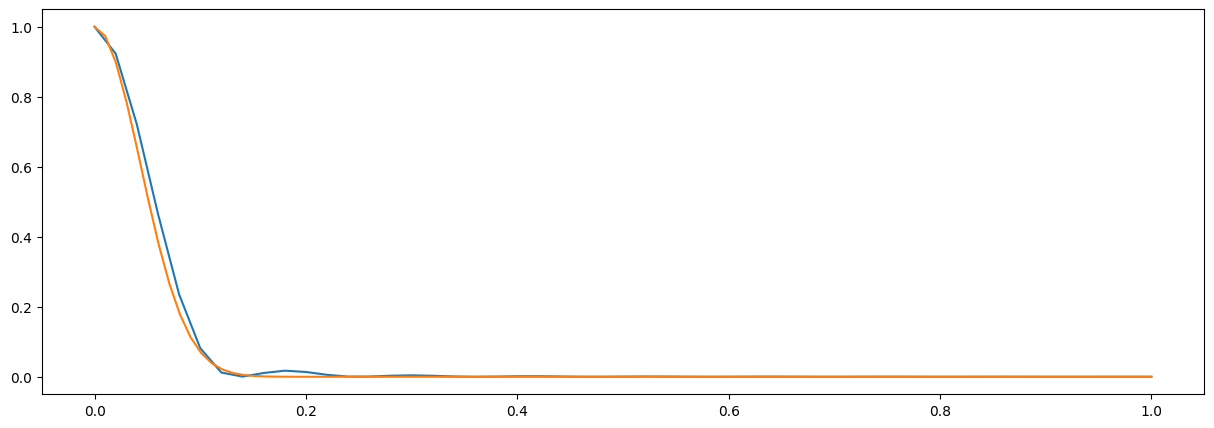

In [13]:
#Checks our model's psf against original psf

with open(FOLDER+'/psf.pkl', 'rb') as file:   
    original_psf = pickle.load(file)

#Normalise x axis of original psf to 1
original_psf_x = np.linspace(0,1,len(original_psf))
original_psf_y = original_psf
plt.plot(original_psf_x,original_psf_y)

new_psf_x = [np.linspace(0,1,100,dtype=np.float32)]
new_psf_y = model.getPSF(torch.tensor(new_psf_x))
new_psf_x = new_psf_x[0]
new_psf_y = new_psf_y.detach().numpy().flatten()
plt.plot(new_psf_x,new_psf_y)
plt.show()


In [14]:
print(model.polynomial_weights.weight.data)
print(model.actual_intensity.weight.data)

tensor([[-2.6408e+02, -1.4291e+01, -1.3690e+00,  4.8065e-02,  2.2056e-01,
         -2.9359e-01, -4.7096e-02]])
tensor([[0.0045, 0.0047, 0.0022,  ..., 0.0039, 0.0030, 0.0065]])


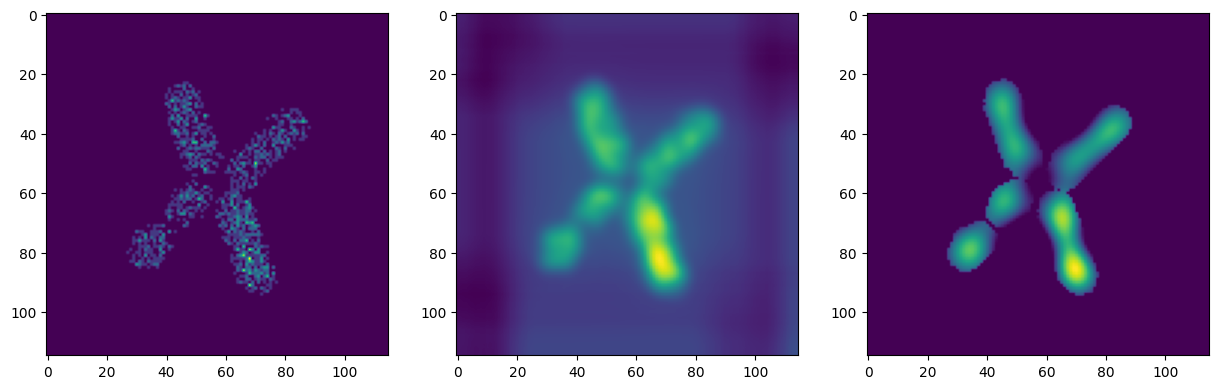

In [15]:
#Recreate original image based off of calculated intensity

customOriginal = np.zeros((maskWidth,maskHeight))
modelIntensity = model.actual_intensity.weight.data[0]
for i in range(len(modelIntensity)):
    customOriginal[sourcePts[i][0]][sourcePts[i][1]] = modelIntensity[i]

oriNormalised = np.asanyarray(ori)
oriNormalised = oriNormalised / max(oriNormalised.flatten())

outNormalised = np.asanyarray(out)
outNormalised = outNormalised / max(outNormalised.flatten())

customOriginal = customOriginal / max(customOriginal.flatten())

f, axarr = plt.subplots(1,3)
axarr[0].imshow(oriNormalised)
axarr[1].imshow(outNormalised)
axarr[2].imshow(customOriginal)
plt.show()


array([[1.        , 0.30685226],
       [0.30685226, 1.        ]])

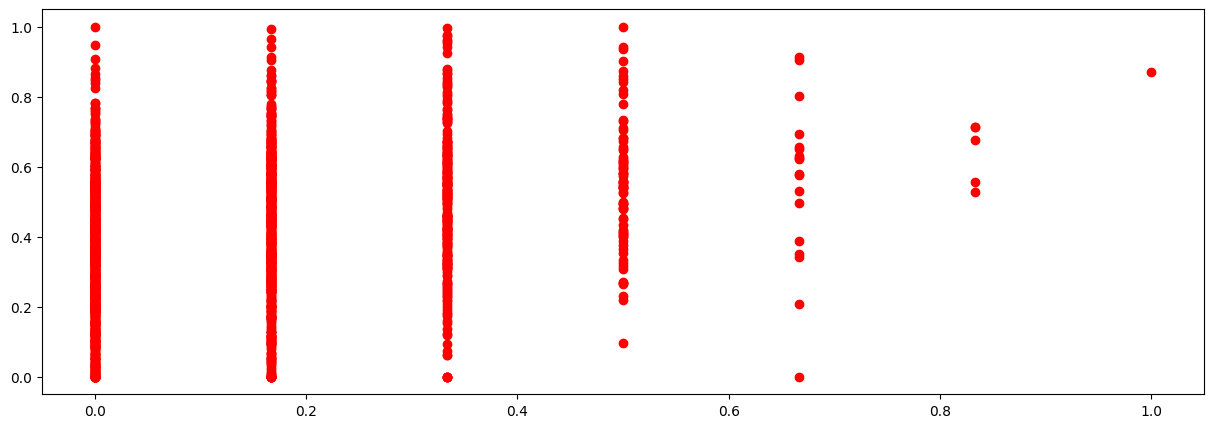

In [16]:
original_intensity = []
custom_intensity = []

for i in range(len(modelIntensity)):
    original_intensity.append(oriNormalised[sourcePts[i][0]][sourcePts[i][1]])
    custom_intensity.append(customOriginal[sourcePts[i][0]][sourcePts[i][1]])

plt.plot(original_intensity,custom_intensity,'ro')

#Calculate correlation coefficient
np.corrcoef(original_intensity,custom_intensity)